# Group 10 - Milestone 3 Notebook
Shristi Pandey, James May, Zachary Werkhoven, Guilherme Braz


**Import libraries**

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
import ADNI_utilities as utils

## Raw Data Aggregation and Cleaning

The code and thought process behind the aggregation and cleaning of the ADNI raw data files is documented in great deal in the following notebooks on the [project respository](https://github.com/jamesm-vt/cs109a_adni): `biomarker_EDA.ipynb`, `diagnosis_EDA.ipynb`, `medical_history.ipynb`, `neuropsych_scores.ipynb`, `rawdata_grouping.ipynb`, and `sub_characteristics.ipynb`.

The resulting per patient data set can be in `patient_firstidx_merge.csv`

## Data Imputation

Some of the complexities with imputation for the ADNI data are that nearly every feature is missing data and there are both categorical and continuous variables to impute. Before imputation, we will prepare the categorical variables. Depending on the study phase, some categorical features use text values like `AD`, `MCI`, `MALE`, `FEMALE`, etc., and others use numerical codes. The per-patient data have been cleaned and standardized to use numeric values. We have stored the appropriate `dtypes` in a separate file.

In [2]:
# Read in the combined (Merged and Per Patient) dataset
pat_comb = pd.read_csv('../data/Per_Patient/pat_merge_b4_impute.csv', index_col='RID')

# Import the dtypes. Categorical variables are represented as int64 as opposed to floats.
dtypes = pd.read_csv('../data/Per_Patient/patient_firstidx_dtypes.csv', index_col='feature_name')

# Categoricals from baseline
categoricals = ['PTETHCAT', 'PTGENDER', 'PTRACCAT', 'PTMARRY', 'FSVERSION', 'APOE4', 'DX_bl']

# Collect categorical columns from pat_data based on dtype=int64
for i in dtypes.index:
    # RID is the index so skip it
    if i == 'RID':
        continue
    # If dtype is int, the it's categorical
    if 'int' in dtypes.loc[i].data_type and i in pat_comb.columns:
        categoricals.append(i)
        
# Remove any dupes
categoricals = list(set(categoricals))

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features and filling in missing values that can be found within the collected data. To deal with the remaining missingness, we will impute values. But first we have to make a decision about whether to scale the data before or after imputation. We have decided to scale the data before imputing missing values. We reason that imputing on the data before scaling may cover up or dilute any bias present in the data. Also, scaling the data before imputation is preferred if we use modeling to impute missing data.

In [3]:
# Scale all columns that are non-categorical
non_cat = list(set(pat_comb.columns) ^ set(categoricals))
pat_comb = utils.standardize_cols(data=pat_comb, cols=non_cat, scaler=MinMaxScaler())

Now we will impute the missing categorical variables. We created a function that takes an estimator and a parameter grid so that we can try imputation with various different models and parameters. The function returns the dataset with categorical variables imputed and a list of tuples containing (for each feature) the best model and score from the grid search.

In [4]:
params = { 
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__splitter":   ["best", "random"],
    "n_estimators": [20, 50, 100]
}

dtc = DecisionTreeClassifier(max_features="auto", class_weight="balanced", max_depth=None)
ada = AdaBoostClassifier(base_estimator=dtc)
pat_comb, ada_scores = utils.impute_values_classification(pat_comb,
                                                      cols=categoricals,
                                                      estimator=ada,
                                                      param_grid=params)

Similarly, we will impute the non-categorical variables. This function also takes an estimator and a parameter grid. Before the final modeling is completed, we will try and evaluate various permutations for imputation and choose the one that performs the best.

In [ ]:
params = {"alpha": [.001, .01, .1, 1]}

lasso_lr = linear_model.Lasso(selection='random', max_iter=3000)
pat_comb, lass_lr_scores = utils.impute_values_regression(pat_comb,
                                                      cols=non_cat,
                                                      estimator=lasso_lr,
                                                      param_grid=params)

Save the inital imputed dataset.

In [6]:
pat_comb.to_csv('../data/Per_Patient/pat_merge_imputed_lasso_ada.csv')

## Preliminary Modeling of the Imputed Data

The goal of this section is to perform some simple modeling on the imputed data set and identify the most important features for prediction. The data includes features with well-known links to Alzheimer's disease. If our data cleaning, imputation, and pre-processing has been done correctly, we should be able to identify these features such as **Amyloid Beta** and **Tau** protein measurements as significant predictors.

**Import Imputed Data**

In [7]:
# read in imputed data from file
imp_df = pd.read_csv("../data/Per_Patient/pat_merge_imputed_lasso_ada.csv")
imp_df.head()

,RID,AGE,PTEDUCAT,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,...,PTMARRY_Widowed,NXFINGER_2.0,PTTLANG_2.0,MH11HEMA_1.0,APGEN2_3.0,APGEN2_4.0,MH16SMOK_1.0,NXABNORM_2.0,NXMOTOR_2.0,MH12RENA_1.0
0,2,0.537838,0.7500,0.667996,0.362173,0.371915,0.152463,0.142146,0.00,0.250059,...,0,0,0,0,1,0,0,0,0,0
1,3,0.727027,0.8750,0.386992,0.376823,0.361000,0.130902,0.132411,0.45,0.515585,...,0,0,0,0,0,1,1,0,0,1
2,4,0.354054,0.3750,0.672628,0.352492,0.867333,0.059918,0.047232,0.10,0.335833,...,0,0,1,0,1,0,1,0,0,1
3,5,0.521622,0.7500,0.595319,0.666659,0.231533,0.210656,0.227054,0.00,0.203187,...,0,0,0,0,1,0,1,0,0,1
4,6,0.702703,0.5625,0.361000,0.256857,0.346205,0.191121,0.212177,0.05,0.437544,...,0,0,0,0,1,0,0,0,0,0


**Split the data**

Since we have multiple potential response variables in our data, we should separate the predictors and the response variables into different data frames.

In [8]:
# define response columns
resp_set = ["DX_BASE","DX_FINAL","DX_CHANGE","DXCOMB","DX_bl"]
col_set = imp_df.columns.tolist()
is_resp = [any([resp in col for resp in resp_set]) for col in col_set]
resp_cols = imp_df.columns[is_resp]

# print response columns
print("Response columns:\n{}".format(resp_cols))

Response columns:
Index(['DXCOMB_2.0', 'DXCOMB_3.0', 'DX_bl_CN', 'DX_bl_MCI', 'DX_BASE_2.0',
       'DX_BASE_3.0', 'DX_FINAL_2.0', 'DX_FINAL_3.0', 'DX_CHANGE_2.0',
       'DX_CHANGE_4.0', 'DX_CHANGE_5.0', 'DX_CHANGE_6.0', 'DX_CHANGE_7.0',
       'DX_CHANGE_8.0', 'DX_CHANGE_9.0'],
      dtype='object')


As we can see from the list above, the response variables have been one-hot-encoded. We can reverse engineer the original classifications to pass in as the response vector for our models.

In [9]:
# iterate of response prefixes
resp_data = []
for resp in resp_set:
    
    # get subset of columns corresponding to currest prefix
    is_subset = [resp in col for col in col_set]
    subset_cols = imp_df.columns[is_subset]
    
    # convert train data to column index of true value
    tmp = np.argmax(imp_df[subset_cols].values,1)+1
    tmp[~imp_df[subset_cols].values.any(1)] = 0
    resp_data.append(tmp)

In [10]:
# drop one-hot response vars and add new features
imp_df = imp_df.drop(columns=resp_cols, axis=1)
for col, data in zip(resp_set, resp_data):
    imp_df[col] = pd.Series(np.array(data), index=imp_df.index)

With the categorical features engineered, we can split the data into train and test sets.

In [11]:
# divide the data into train and test sets
train_df, test_df = train_test_split(imp_df, test_size=0.2, shuffle=True)

# define new dataframe with response vars
y_train = train_df[resp_set]
x_train = train_df.drop(columns=resp_set, axis=1)
y_test = test_df[resp_set]
x_test = test_df.drop(columns=resp_set, axis=1)

## Logistic Regression

To train a model, we'll need to select a response variable from the set of:
- baseline diagnosis `DX_BASE`
- ADNI merge baseline diagnosis `DX_bl`
- final diagnosis `DX_FINAL`
- change in diagnosis from baseline to final `DX_CHANGE`

If we want to develop a model to predict ultimate diagnosis based on baseline measures, it makes sense to choose `DX_FINAL` as the response variable.

In [ ]:
# define and fit logistic regression model
resp_var = 'DX_FINAL'
logit = LogisticRegressionCV(Cs=10,cv=3, solver='newton-cg', multi_class='multinomial', max_iter=100)
logit = logit.fit(x_train.values, y_train[resp_var].values)

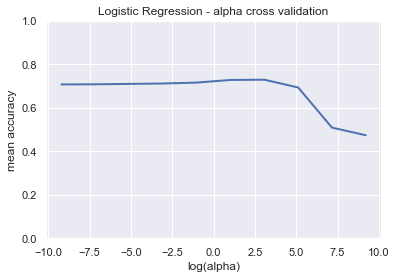

In [13]:
# plot cv accuracy as a function of alpha
plt.plot(np.log(1/logit.Cs_), logit.scores_[0].mean(0), lw=2)
plt.ylim(0,1)
plt.xlabel("log(alpha)")
plt.ylabel("mean accuracy")
plt.title("Logistic Regression - alpha cross validation");

From the plot above we can see the optimal value for our regularization parameter is somewhere between 0-100.

In [14]:
# report test and train accuracy
print("Train accuracy = {0:.3f}".format(logit.score(x_train.values, y_train[resp_var].values)))
print("Test accuracy = {0:.3f}".format(logit.score(x_test.values, y_test[resp_var].values)))

Train accuracy = 0.789
Test accuracy = 0.741


The performancy of the model is significantly worse on the test data, suggesting that the model is likely overfit. Many of the coefficients are likely to be very close to zero. To get some sense of the coefficients of our models, we can start by plotting the log histogram of our coefficient magnitudes to help separate the values.

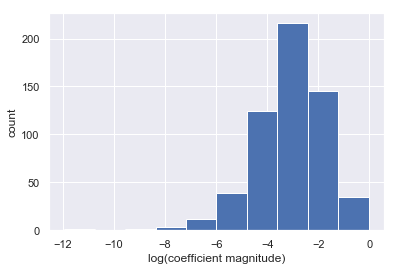

In [15]:
# plot log histogram
plt.hist(np.log(np.abs(logit.coef_.flatten())))
plt.ylabel("count")
plt.xlabel("log(coefficient magnitude)");

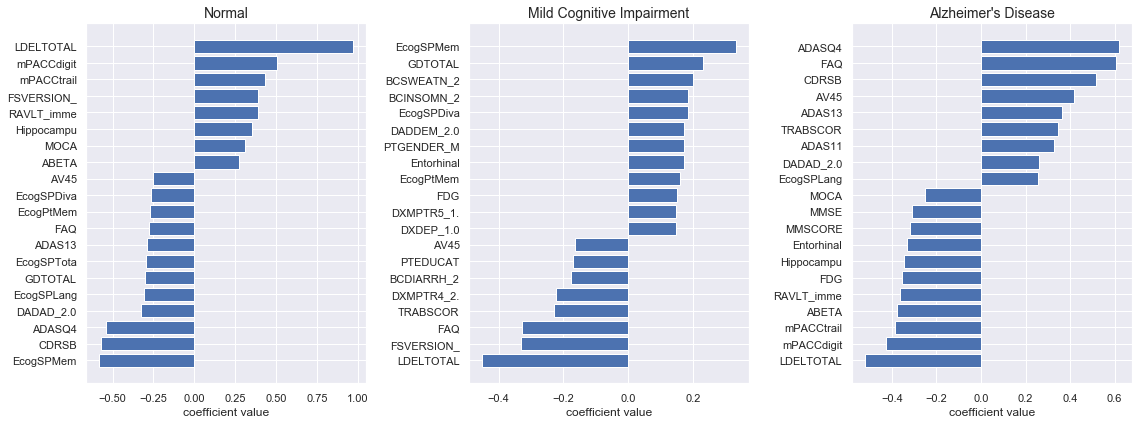

In [16]:
# plot top coefficients (by magnitude) for each model
f, ax = plt.subplots(1,3, figsize=(16,6))
coef_mag = np.abs(logit.coef_)
class_names = ["Normal","Mild Cognitive Impairment","Alzheimer's Disease"]

for i in range(len(ax)):
    
    # get indices of top parameters
    coef_idx = np.argsort(coef_mag[i,:])[-20:]
    coef_idx = coef_idx[np.argsort(logit.coef_[i,coef_idx])]
    
    # create horizontal bar plot
    ax[i].barh(np.arange(len(coef_idx)), logit.coef_[i,coef_idx], align='center', color='b')
    ax[i].set_yticks(np.arange(len(coef_idx)))
    y_labels = [col[:10] for col in x_train.columns[coef_idx].tolist()]
    ax[i].set_yticklabels(y_labels)
    ax[i].set_xlabel('coefficient value')
    ax[i].set_title(class_names[i], FontSize=14)
    
plt.tight_layout()

From the coefficient values above, we can see that many of the model coefficients match our expectations. For example, Tau, pTau, and the clinical dementia rating are all significantly positively predictive of Alzheimer's disease. However, there are some confusing results as well that will warrant further investigation. For example, Amyloid Beta levels in the cerebrospinal fluid are negatively predictive of Alzheimer's, which does not match our expectation.

## Random Forest Classifier

Given that the logistic regression model above was overfit, one simple thing to try is an ensemble classifier such as random forest that will offer the low model variance advantage of bagging. Let's try it out and see if the performance on the test set improves.

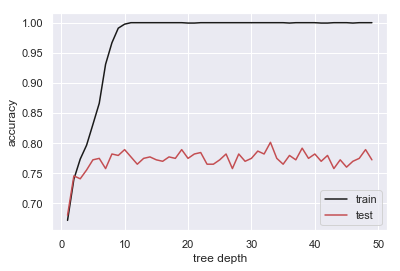

In [17]:
# define and fit logistic regression model
from sklearn.ensemble import RandomForestClassifier
resp_var = 'DX_FINAL'
depths = np.arange(1,50,1)
train_acc = np.empty(depths.shape[0])
test_acc = np.empty(depths.shape[0])

for i, depth in enumerate(depths):
    
    # train temp model
    rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=depth)
    rfc = rfc.fit(x_train.values, y_train[resp_var].values)
    train_acc[i] = rfc.score(x_train.values, y_train[resp_var].values)
    test_acc[i] = rfc.score(x_test.values, y_test[resp_var].values)
    
plt.plot(depths, train_acc, color='k', label="train")
plt.plot(depths, test_acc, color='r', label="test");
plt.xlabel("tree depth")
plt.ylabel("accuracy")
plt.legend();

In [18]:
# define tree model
rand_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6)
rand_forest = rand_forest.fit(x_train.values, y_train[resp_var].values)

In [19]:
# report test and train accuracy
print("Train accuracy = {0:.3f}".format(rand_forest.score(x_train.values, y_train[resp_var].values)))
print("Test accuracy = {0:.3f}".format(rand_forest.score(x_test.values, y_test[resp_var].values)))

Train accuracy = 0.877
Test accuracy = 0.780
